## **Feature:** Dataset Summaries

**Names:** Dhruv

### **What it does**
Generates statistical summaries including descriptive statistics (mean, median, mode, variance, std, quartiles), distribution analysis, correlation matrices, and basic visualisations for dataset exploration.

### **Helper Functions**
- calculate_basic_stats(df, columns=None): Calculate mean, median, std, variance, skewness, kurtosis for numeric columns
- calculate_five_number_summary(df, columns=None): Calculate min, Q1, median, Q3, max, IQR for numeric columns
- calculate_mode_stats(df, columns=None): Calculate mode, frequency, unique values for all columns
- generate_correlation_matrix(df, method='pearson'): Create correlation matrix and heatmap for numeric columns
- create_distribution_plots(df, columns=None, max_plots=6): Create histograms for numeric columns
- analyse_categorical_columns(df, columns=None, top_n=5): Analyse categorical columns with frequency tables
    """

In [13]:
# Get API Key
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    print("OpenAI API Key not found")

# Import libraries
import pandas as pd
import numpy as np
import math
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Langchain imports
from langchain.chat_models import ChatOpenAI  
from langchain.schema import HumanMessage, SystemMessage

In [28]:
def numerical_summary(df, columns=None, metrics=None):
    """
    Returns summary dataframe for given columns of numeric type

    - params:
        - columns: list[str] or None (defaults to numeric columns)
        - metrics: list[str] subset of ['count','missing','mean','std', 'var', 'min','median','q1','q3','max','skew','range', 'iqr']
    - returns: pd.DataFrame
    """
     
    if not isinstance(df, pd.DataFrame):
        return pd.DataFrame()
    
    # Default to numeric columns if no specific columns given
    if columns:
        columns = [col for col in columns if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    else:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()

    if not columns:
        return pd.DataFrame

    filtered_df = df[columns]

    # Default metric set
    default_metrics = {
        "count": filtered_df.count(),
        "missing": filtered_df.isna().sum(),
        "mean": filtered_df.mean(),
        "std": filtered_df.std(),
        "var": filtered_df.var(),
        "min": filtered_df.min(),
        "q1": filtered_df.quantile(0.25),
        "median": filtered_df.median(),
        "q3": filtered_df.quantile(0.75),
        "max": filtered_df.max(),
        "skew": filtered_df.skew(),
        "iqr": filtered_df.quantile(0.75) - filtered_df.quantile(0.25), 
        "range": filtered_df.max() - filtered_df.min()
    }
    
    # Filter to requested metrics (always including count)
    if metrics:
        metrics = {m.lower() for m in metrics}
        output_cols = {"count": default_metrics["count"]}
        for d in default_metrics:
            if d != "count" and d in metrics:
                output_cols[d] = default_metrics[d]
    else:
        output_cols = default_metrics
    
    output_df = pd.DataFrame(output_cols)
    print(output_df)
    return df

In [29]:
def categorical_summary(df, columns=None, metrics=None):
    """
    Returns summary dataframe for given columns of categorical type

    - params:
        - columns: list[str] or None (defaults to non-numeric columns)
        - metrics: list[str] subset of ['count', 'missing', 'nunique', 'mode', 'top_freq']
    - returns: pd.DataFrame
    """

    if not isinstance(df, pd.DataFrame):
        return pd.DataFrame()

    # Default to non-numeric columns if no specific columns given
    if columns:
        columns = [col for col in columns if col in df.columns]
    else:
        columns = [col for col in df.select_dtypes(include='object')]

    if not columns:
        return pd.DataFrame()
    
    filtered_df = df[columns]

    default_metrics = {
        "count": filtered_df.count(),
        "missing": filtered_df.isna().sum(),
        "nunique": filtered_df.nunique(dropna=True),
        "mode": filtered_df.apply(lambda col: col.mode(dropna=True).iloc[0] if not col.mode(dropna=True).empty else np.nan),
        "top_freq": filtered_df.apply(lambda col: col.value_counts(dropna=True).iloc[0] if not col.value_counts(dropna=True).empty else 0)
    }
    if metrics:
        metrics = {m.lower() for m in metrics}
        output_cols = {"count": default_metrics["count"]}
        for d in default_metrics:
            if d != "count" and d in metrics:
                output_cols[d] = default_metrics[d]
    else:
        output_cols = default_metrics

    output_df = pd.DataFrame(output_cols)
    print(output_df)
    return df

In [ ]:
def calculate_mode_stats(df, columns=None, metrics=None):
    """
    Returns summary dataframe for given columns of categorical type

    - params:
        - columns: list[str] or None
        - metrics: list[str] subset of ['mode', 'mode_frequency', 'unique_values', 'most_frequent_values']
    - returns: pd.DataFrame
    """
    if columns is None:
        columns = df.columns

    # Default metrics
    all_metrics = ['mode', 'mode_frequency', 'unique_values', 'most_frequent_values']
    if metrics is not None:
        metrics = [m for m in metrics if m in all_metrics]
    else:
        metrics = all_metrics

    mode_stats = {}
    for col in columns:
        if col in df.columns:
            stats = {
                'mode': df[col].mode().iloc[0] if not df[col].mode().empty else None,
                'mode_frequency': df[col].value_counts().iloc[0] if not df[col].value_counts().empty else 0,
                'unique_values': df[col].nunique(),
                'most_frequent_values': df[col].value_counts().head(3).to_dict()
            }
            # Only keep requested metrics
            mode_stats[col] = {k: stats[k] for k in metrics}
    print(mode_stats)
    return df

In [8]:
def generate_correlation_matrix(df, method='pearson'):
    """Generate correlation matrix and heatmap for numeric columns"""
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.empty:
        print("No numeric columns found for correlation analysis")
        return None
    
    correlation_matrix = numeric_df.corr(method=method)
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5)
    plt.title(f'Correlation Matrix ({method.title()})')
    plt.tight_layout()
    plt.show()
    
    print(correlation_matrix)

    return df

In [31]:
def create_distribution_plots(df, columns=None, max_plots=6):
    """Create distribution plots and histograms for numeric columns"""
    if columns is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
    else:
        numeric_cols = [col for col in columns if col in df.columns and df[col].dtype in ['int64', 'float64']]
    
    numeric_cols = numeric_cols[:max_plots]  # Limit number of plots
    
    if len(numeric_cols) == 0:
        print("No numeric columns found for distribution plots")
        return
    
    n_cols = min(3, len(numeric_cols))
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [33]:
def get_summaries(df, user_query):
    """
    Main function that gets called by the main router.
    MUST take (user_query, df) and return df
    """

    # TODO: Create helper docs (Reimplement with functions)
    helper_docs = """
    - numerical_summary(df, columns=None, metrics=None): Returns a numeric summary DataFrame for given columns. 
    prints summary of given metrics for given columns in dataframe of numeric type only
        - params:
            - columns: list[str] or None (defaults to numeric columns)
            - metrics: list[str] subset of ["count","missing","mean","std","min","median","q1","q3","max","skew","range", "iqr"]
    - def categorical_summary(df, columns=None, metrics=None)
    prints summary of given metrics for given columns in dataframe
        - params:
            - columns: list[str] or None (defaults to non-numeric columns)
            - metrics: list[str] subset of ['count', 'missing', 'nunique', 'mode', 'top_freq']
    - def calculate_mode_stats(df, columns=None, metrics=None): 
    prints summary of given metrics for given columns in dataframe
        - params:
            - columns: list[str] or None (defaults to non-numeric columns)
            - metrics: list[str] subset of ['mode', 'mode_frequency', 'unique_values', 'most_frequent_values']

    - generate_correlation_matrix(df, method='pearson'): Create correlation matrix and heatmap for numeric columns
    - create_distribution_plots(df, columns=None, max_plots=6): Create histograms for numeric columns
    """
    
    # Create message chain
    messages = []
    messages.append(SystemMessage(content=f"""
    You are a data cleaning agent trying to generate dataset summaries.
    
    Dataset info: Shape: {df.shape}, Sample: {df.head(3).to_string()}
    
    Helper functions available (USE PANDAS WHERE POSSIBLE): 
    {helper_docs}

    Libraries available:
    - pd (pandas), np (numpy)
    - math, re, datetime
    - preprocessing, impute (from sklearn)
    - plt (matplotlib.pyplot), sns (seaborn)
    - stats (from scipy)
    
    BASIC SUMMARIES
    - df.shape(): rows and columns
    - 5 number summary (numerical): 'IQR', 'Q3', 'Q1', 'Median', 'Mean' 
    - (categorical): mode, nunique, top_freq

    Rules:
    - Return only executable Python code, no explanations, no markdown blocks
    - Use helper functions if needed
    - For specific columns mentioned in query, pass them as lists to helper functions
    - ASSUME DF IS ALREADY DEFINED
    - In order to generate a response/message to the user use print statements
    print("message")
    - Write a detailed print message to summarise actions taken and reasons

    Examples:
    - "correlation matrix" -> generate_correlation_matrix(df)
    - "summary of all data" -> use multiple helper functions
    - "distribution plots" -> create_distribution_plots(df)
    """))
    messages.append(HumanMessage(content=f"User request: {user_query}"))
    
    # Call LLM with message chain
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    response = llm.invoke(messages)
    generated_code = response.content.strip()
    
    # Execute code
    try:
        original_df = df.copy()
        exec(generated_code)
        return df
    except Exception as e:
        print(f"Error: {e}")
        print(f"Generated Code:{generated_code}")
        return original_df

Generating distribution plots for the weight columns in the dataset. I will create histograms for the numeric columns that represent weights. Let's proceed with the visualization.


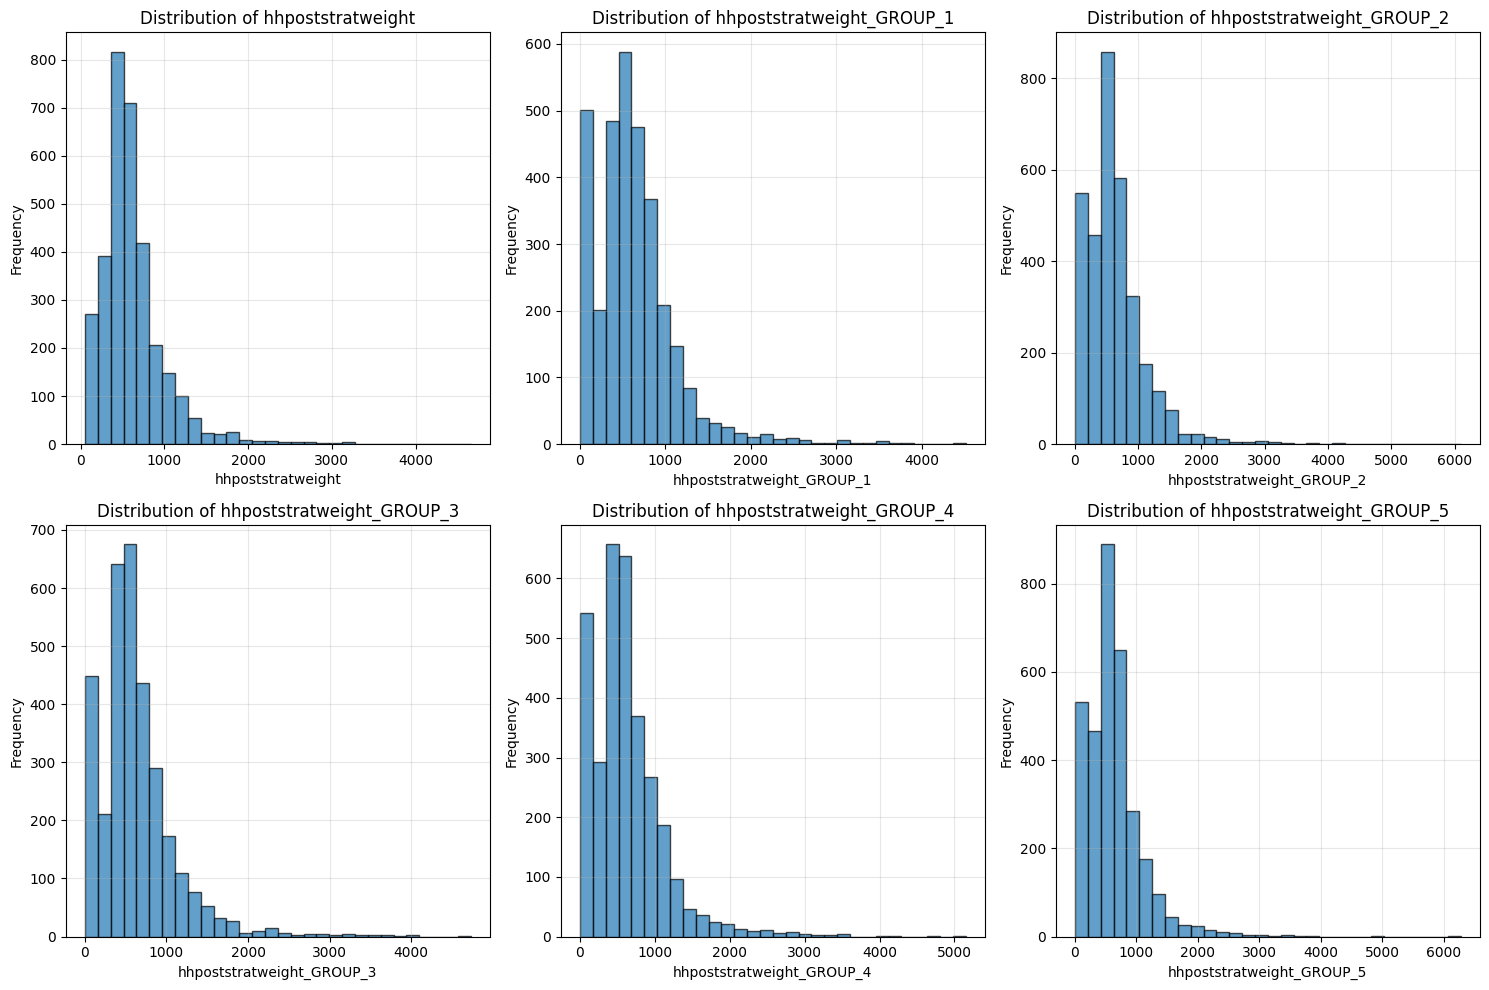

,hhid,surveyperiod,hhsize,dwelltype,owndwell,totalbikes,totalvehs,travmonth,travdow,homelga,...,hhpoststratweight_GROUP_4,hhpoststratweight_GROUP_5,hhpoststratweight_GROUP_6,hhpoststratweight_GROUP_7,hhpoststratweight_GROUP_8,hhpoststratweight_GROUP_9,hhpoststratweight_GROUP_10,homesubregion_ASGS,homeregion_ASGS,dayType
0,Y24H5740102,2023-24,2,"Unit, Flat or Apartment",Being Rented,0,2,July,Tuesday,Casey (C),...,794.474555,1004.367427,0.000000,819.042660,845.207499,772.543906,1371.009680,MELB - Outer,Greater Melbourne,Weekday
1,Y24H5740103,2023-24,1,Separate House,Fully Owned,0,1,July,Wednesday,Casey (C),...,632.661609,768.531066,0.000000,643.885310,618.385880,658.309756,966.565030,MELB - Outer,Greater Melbourne,Weekday
2,Y24H5740104,2023-24,1,Separate House,Being Rented,1,0,July,Thursday,Casey (C),...,879.287666,876.720143,0.000000,767.541531,669.950307,782.666670,1070.357088,MELB - Outer,Greater Melbourne,Weekday
3,Y24H5740109,2023-24,5,Separate House,Being Purchased,5,1,July,Tuesday,Casey (C),...,939.288509,1086.536723,0.000000,891.080477,914.838332,837.523127,1134.029424,MELB - Outer,Greater Melbourne,Weekday
4,Y24H5740110,2023-24,3,Separate House,Being Rented,1,1,July,Wednesday,Casey (C),...,683.310054,776.546409,0.000000,657.057638,619.735659,660.924173,967.732619,MELB - Outer,Greater Melbourne,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3234,Y24H6250431,2023-24,3,Separate House,Being Rented,3,1,July,Wednesday,Moonee Valley (C),...,0.000000,352.663078,425.652772,564.352450,420.757706,373.239663,630.180891,MELB - Middle,Greater Melbourne,Weekday
3235,Y24H6250432,2023-24,1,Separate House,Fully Owned,0,1,July,Thursday,Moonee Valley (C),...,0.000000,411.434625,425.537607,589.945324,480.693459,408.620863,535.288261,MELB - Middle,Greater Melbourne,Weekday
3236,Y24H6250438,2023-24,4,Separate House,Being Purchased,3,3,July,Wednesday,Moonee Valley (C),...,0.000000,354.942408,367.206506,458.200711,383.721908,345.424338,524.457906,MELB - Middle,Greater Melbourne,Weekday
3237,Y24H6250440,2023-24,1,Separate House,Fully Owned,0,1,July,Friday,Moonee Valley (C),...,0.000000,455.381881,458.453130,622.719377,519.850443,441.250921,558.647242,MELB - Middle,Greater Melbourne,Weekday


In [36]:
# TEST OUT YOUR FEATURE
df = pd.read_csv("../sample_data/household_vista_2023_2024.csv")[0:5000]
## Import Data

## Run code
get_summaries(df, "help me visualise distributions for the weight columns")